In [1]:
from models import Chan_Model
from models import  build_receiver_model
from keras.utils import to_categorical
import tensorflow as tf
import pickle
import os 
import random
import collections
import matplotlib.pyplot as plt
import h5py
from keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

2023-06-19 11:36:20.190901: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 11:36:21.478220: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-19 11:36:21.478243: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-06-19 11:36:21.478406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class ClevrDataset(tf.keras.utils.Sequence):
    def __init__(self, data_dir, split='train'):
        with open(os.path.join(data_dir, '{}.pkl'.format(split)), 'rb') as f:
            self.data = pickle.load(f)

        self.data_dict = collections.defaultdict(list)
        for item in self.data:
            _, _, answer, _ = item
            self.data_dict[answer].append(item)

        self.shuffle()
        self.img = h5py.File(os.path.join(data_dir, 'image_{}.h5'.format(split)), 'r')
        self.max_question_length = 46  # max_len + 1
        self.num_classes = 28  # max_len + 1

    def shuffle(self):
        self.data = []
        for _, items in self.data_dict.items():
            self.data += items
        random.shuffle(self.data)

    def get_max_answer(self):
        max_answer = 0
        for index in range(len(self.data)):
            _, _, answer, _ = self.data[index]
            if answer > max_answer:
                max_answer = answer
        return max_answer + 1

    def get_max_question_length(self):
        max_len = 0
        for index in range(len(self.data)):
            _, question, _, _ = self.data[index]
            if len(question) > max_len:
                max_len = len(question)
        return max_len + 1

    def pad_question(self, question):
        if len(question) >= self.max_question_length:
            question_padded = question[:self.max_question_length]
        else:
            question_padded = question + [0] * (self.max_question_length - len(question))
        return question_padded

    def __getitem__(self, index):
        imgfile, question, answer, family = self.data[index]
        id = int(imgfile.rsplit('_', 1)[1][:-4])
        img = tf.convert_to_tensor(self.img[f'image_{id}'][()] / 255., dtype=tf.float32)

        # Padding
        question_padded = self.pad_question(question)
        return img, question_padded, to_categorical(answer, num_classes=self.num_classes)

    def __len__(self):
        return len(self.data)

In [3]:
def test_performance(test_dataset):
    tx_model = load_model("../trained_model_sc_vqa/tx_model.h5")
    rx_model = build_receiver_model()
    weights_load = np.load('../trained_model_sc_vqa/rx_model_weights.npy', allow_pickle=True)
    rx_model.set_weights(weights_load)
    snr = 10
    channel_type = 'awgn'
    
    chan_layer = Chan_Model('Channel')

    X_test, ques_test, ans_test = next(iter(test_dataset))

    img_chan_output, txt_chan_output = tx_model.predict([X_test, ques_test])
    # Channel
    img_tx_chan = chan_layer(img_chan_output, snr, channel_type=channel_type)
    txt_tx_chan = chan_layer(txt_chan_output, snr, channel_type=channel_type)

    cls_output = rx_model.predict([img_tx_chan, txt_tx_chan])
    from sklearn.metrics import accuracy_score

    y_true = np.argmax(ans_test, axis=1)
    y_pred = np.argmax(cls_output, axis=1)
    acc = accuracy_score(y_true, y_pred)
    print("channel_type = {}, snr_db = {}, acc = {} %".format(channel_type, snr, acc * 100))

    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    df_mat = pd.DataFrame(conf_mat)
    sn.set(font_scale=0.7)
    sn.heatmap(df_mat, annot=True, annot_kws={"size": 8}, cmap='Blues')
    plt.show()

In [4]:
val_dataset = ClevrDataset(data_dir='data/', split="val")
val_dataloader = tf.data.Dataset.from_generator(lambda: val_dataset,
                output_signature=(
                tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(46), dtype=tf.int32),
                tf.TensorSpec(shape=(28), dtype=tf.int32),))
val_dataloader = val_dataloader.batch(256)

8/8 [==============================] - 1s 57ms/step
channel_type = awgn, snr_db = 10, acc = 25.390625 %


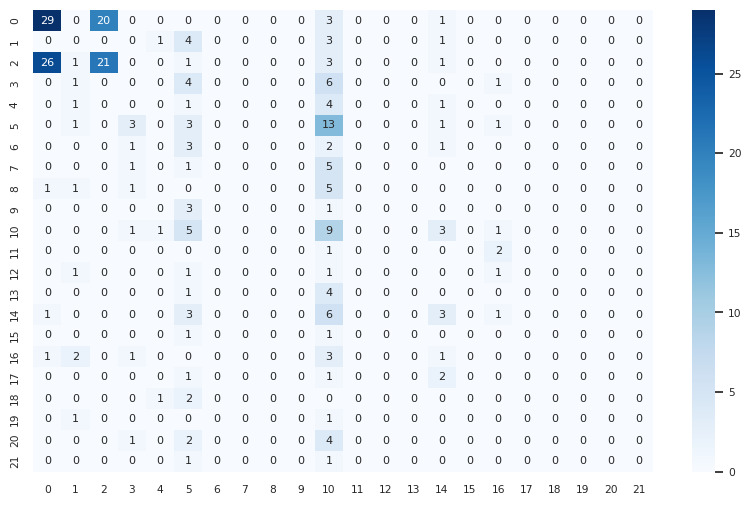

In [5]:
test_performance(val_dataloader)